In [2]:
import os 
import pandas as pd
import json
from tqdm import tqdm
import numpy as np
import glob
import itertools
import pickle
from scipy import stats

import matplotlib.cm as cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns=100
pd.options.display.max_rows=100
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Functions

In [3]:
def transform_allele_poly(r):
    r=r.upper().replace("HLA_","")
    return r[0]+"*"+r[2:4]+":"+r[5:7]
    
def read_polysolver(path):
    l=[]
    if not(os.path.exists(path)):
        return []
    with open(path,'r') as f:
        for line in f.readlines():
            line = line.rstrip()
            _,hla_1,hla_2 = line.split("\t")
            p_hla_1,p_hla_2 = transform_allele_poly(hla_1),transform_allele_poly(hla_2)
            l+=[p_hla_1,p_hla_2]
            
    return l
def read_hlas_xhla(path):
    if not(os.path.exists(path)):
        return []
    with open(path, 'r') as f:
        d = json.load(f)["hla"]
    list_normal_total = [get_4digit_xhla(hla) for hla in d["alleles"]]
    list_normal_I = list([hla for hla in list_normal_total if hla[4] != "D"]) # only class I at this moment
    list_normal_parsed = [hla[4]+"*"+hla[5:] for hla in list_normal_I]
    return list_normal_parsed

def get_4digit_xhla(hla):
    v = "HLA-" + hla.replace("*", "")
    if v[-1] == "N": # this allele is raising an error...
        return v[0:-1] # remove the "N" of the final...
    return v            

### Read all the output

In [8]:
df_meta = pd.read_csv("../metadata/dataset_metadata_supp_table3.tsv",sep="\t") # This is Supp. Table 3
df_meta=df_meta[(df_meta["cohort"]=="Hartwig")&(df_meta["is_selected"]==True)]
donors = df_meta["sample_id"].values

In [10]:
df_meta["blacklist_gie_comment"].value_counts()

Series([], Name: blacklist_gie_comment, dtype: int64)

### Check Harwtig output for the HLA-I typing of the three tools

In [36]:
d_data={}
for donor in tqdm(donors):
    filein1=f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/lilac_validation/{donor}/{donor}_normal.lilac.csv.gz"
    filein2=f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/lilac_validation/{donor}/{donor}_tumor.lilac.csv.gz"
    if not(os.path.exists(filein1)):
        continue
    df=pd.read_csv(filein1,sep=",")
    df1=pd.read_csv(filein2,sep=",")
    alleles_normal_lilac = df["Allele"].values
    alleles_tumor_lilac = df1["Allele"].values
    
    # find polysolver
    path_normal_polysolver=f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/hla_events/{donor}/typing_normal/winners.hla.txt"
    path_tumor_polysolver=f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/hla_events/{donor}/typing_tumor/winners.hla.txt"
    alleles_normal_poly = read_polysolver(path_normal_polysolver)
    alleles_tumor_poly = read_polysolver(path_tumor_polysolver)
    # find xhla
    path_normal_xhla=f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/hla_events/{donor}/typing_normal_xhla/report-{donor}-hla.json"
    path_tumor_xhla=f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/hla_events/{donor}/typing_tumor_xhla/report-{donor}-hla.json"
    alleles_normal_xhla = read_hlas_xhla(path_normal_xhla)
    alleles_tumor_xhla = read_hlas_xhla(path_tumor_xhla)
    # general
    valid_donor = len(alleles_normal_poly) > 0 and len(alleles_tumor_poly) > 0 and len(alleles_normal_xhla) > 0 and len(alleles_tumor_xhla) > 0
    # general
    d_data[donor] = {"polysolver":{"normal":alleles_normal_poly,"tumor":alleles_tumor_poly},"xHLA":{"normal":alleles_normal_xhla,"tumor":alleles_tumor_xhla},"LILAC":{"normal":alleles_normal_lilac,"tumor":alleles_tumor_lilac},"has_full_output":valid_donor}

100%|██████████| 4439/4439 [1:11:19<00:00,  1.04it/s]


### Save dictionary

In [37]:
av_donors=list(d_data.keys())
for k in av_donors:
    if k in donors:
        d_data[k]["LILAC"]["normal"] = list(d_data[k]["LILAC"]["normal"])
        d_data[k]["LILAC"]["tumor"] = list(d_data[k]["LILAC"]["tumor"])
    else:
        del d_data[k]
with open("data/per_sample_HLA_type.json",'w') as f: # tmp file, only for internal use
    json.dump(d_data,f)    

### Read dictionary

In [39]:
with open("data/per_sample_HLA_type.json") as f:
    d_data = json.load(f)

In [40]:
df= pd.read_csv("../results/data/processed_hmf_escape_info.tsv",sep="\t").rename(columns={"sample":"sample_id"}) # Supp. Table 4
df = df[df["sample_id"].isin(d_data.keys())]

/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (16,17,19,20,142) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [41]:
d_data_full={}
for sample in d_data:
    if d_data[sample]["has_full_output"] and sample in df["sample_id"].unique():
        d_data_full[sample] = d_data[sample]

In [42]:
len(d_data)

4439

### Plot HMF

In [44]:
pallete = {"wt":"#ef8a62","alteration":"#67a9cf","alteration_primary":"#7570b3"}

In [45]:
def get_samples_match(d_data,key,samples=[]):
    c=0
    for donor in d_data:
        if len(samples) > 0 and not(donor) in samples:
            continue
        a=len(set(d_data[donor][key]["normal"]).symmetric_difference(set(d_data[donor][key]["tumor"])))
        c+=int((a>0 or len(d_data[donor][key]["normal"]) == 0 or len(d_data[donor][key]["tumor"]) == 0 ))
    return c

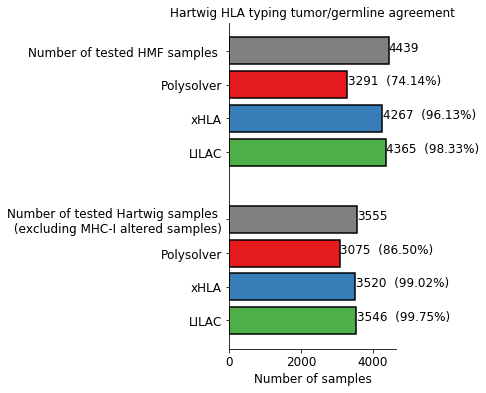

In [46]:
total_samples = len(d_data_full)
# general 
samples_with_hla_typing_polysolver = total_samples - get_samples_match(d_data_full,"polysolver")
samples_with_hla_typing_xhla = total_samples - get_samples_match(d_data_full,"xHLA")
samples_with_hla_typing_LILAC = total_samples - get_samples_match(d_data_full,"LILAC")

fig,ax = plt.subplots(figsize=(3,6))
colors = {"polysolver":"#e41a1c","xhla":"#377eb8","LILAC":"#4daf4a"}
yticks_labels = ["Number of tested HMF samples "]
yticks = []
y=0
ax.barh(y=y,width=total_samples,color="grey",edgecolor="black",linewidth=1.5)
ax.annotate(xy=(total_samples+10,y),s=str(total_samples),fontsize=12 )
yticks.append(y)
y-=1
yticks_labels.append("Polysolver")
ax.barh(y=y,width=samples_with_hla_typing_polysolver,color=colors["polysolver"],edgecolor="black",linewidth=1.5)
ax.annotate(xy=(samples_with_hla_typing_polysolver+10,y),s=str(samples_with_hla_typing_polysolver) + "  ({0:.2%})".format(samples_with_hla_typing_polysolver/total_samples),fontsize=12)
yticks_labels.append("xHLA")
yticks.append(y)
y-=1
ax.barh(y=y,width=samples_with_hla_typing_xhla,color=colors["xhla"],edgecolor="black",linewidth=1.5)
ax.annotate(xy=(samples_with_hla_typing_xhla+10,y),s=str(samples_with_hla_typing_xhla) + "  ({0:.2%})".format(samples_with_hla_typing_xhla/total_samples),fontsize=12)
yticks_labels.append("LILAC")
yticks.append(y)
y-=1
ax.barh(y=y,width=samples_with_hla_typing_LILAC,color=colors["LILAC"],edgecolor="black",linewidth=1.5)
ax.annotate(xy=(samples_with_hla_typing_LILAC+10,y),s=str(samples_with_hla_typing_LILAC) + "  ({0:.2%})".format(samples_with_hla_typing_LILAC/total_samples),fontsize=12)
yticks.append(y)

df_wt = df[(df["loh_lilac"]==False)&(df["del_HLA-A"]==0)&(df["del_HLA-B"]==0)&(df["del_HLA-C"]==0)&(df["mut_hla_lilac"]==False)]
total_samples = list(df_wt["sample_id"].values)

# general 
samples_with_hla_typing_polysolver = len(total_samples) - get_samples_match(d_data_full,"polysolver",df_wt["sample_id"].values)
samples_with_hla_typing_xhla = len(total_samples) - get_samples_match(d_data_full,"xHLA",df_wt["sample_id"].values)
samples_with_hla_typing_LILAC = len(total_samples) - get_samples_match(d_data_full,"LILAC",df_wt["sample_id"].values)

y-=2
yticks_labels.append("Number of tested Hartwig samples \n (excluding MHC-I altered samples)")
ax.barh(y=y,width=len(total_samples),color="grey",edgecolor="black",linewidth=1.5)
ax.annotate(xy=(len(total_samples)+10,y),s=str(len(total_samples)),fontsize=12)
yticks.append(y)
y-=1
yticks_labels.append("Polysolver")
ax.barh(y=y,width=samples_with_hla_typing_polysolver,color=colors["polysolver"],edgecolor="black",linewidth=1.5)
ax.annotate(xy=(samples_with_hla_typing_polysolver+10,y),s=str(samples_with_hla_typing_polysolver) + "  ({0:.2%})".format(samples_with_hla_typing_polysolver/len(total_samples)),fontsize=12)
yticks_labels.append("xHLA")
yticks.append(y)
y-=1
ax.barh(y=y,width=samples_with_hla_typing_xhla,color=colors["xhla"],edgecolor="black",linewidth=1.5)
ax.annotate(xy=(samples_with_hla_typing_xhla+10,y),s=str(samples_with_hla_typing_xhla) + "  ({0:.2%})".format(samples_with_hla_typing_xhla/len(total_samples)),fontsize=12)
yticks_labels.append("LILAC")
yticks.append(y)
y-=1
ax.barh(y=y,width=samples_with_hla_typing_LILAC,color=colors["LILAC"],edgecolor="black",linewidth=1.5)
ax.annotate(xy=(samples_with_hla_typing_LILAC+10,y),s=str(samples_with_hla_typing_LILAC) + "  ({0:.2%})".format(samples_with_hla_typing_LILAC/len(total_samples)),fontsize=12)
yticks.append(y)

ax.set_yticks(yticks)
ax.set_yticklabels(yticks_labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Number of samples",fontsize=12)
ax.set_title("Hartwig HLA typing tumor/germline agreement",fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(f'../results/figures/figure1/Hartwig_tumor_normal_agreement.pdf', dpi=800,bbox_inches="tight")

In [47]:
from matplotlib_venn import venn3, venn3_circles

In [48]:
l=[0,0,0,0,0,0,0]
for donor in d_data_full:
    # only one method
    lilac_only = len( set(d_data_full[donor]["LILAC"]["normal"]) - set(d_data_full[donor]["polysolver"]["normal"]) - set(d_data_full[donor]["xHLA"]["normal"])) > 0
    poly_only = len(set(d_data_full[donor]["polysolver"]["normal"]) - set(d_data_full[donor]["LILAC"]["normal"]) - set(d_data_full[donor]["xHLA"]["normal"])) > 0
    xhla_only = len(set(d_data_full[donor]["xHLA"]["normal"]) - set(d_data_full[donor]["polysolver"]["normal"]) - set(d_data_full[donor]["LILAC"]["normal"])) > 0
    
    # two methods 
    lilac_polysolver=len(set(d_data_full[donor]["LILAC"]["normal"]).intersection(set(d_data_full[donor]["polysolver"]["normal"])) - set(d_data_full[donor]["xHLA"]["normal"])) > 0
    lilac_xhla=len(set(d_data_full[donor]["LILAC"]["normal"]).intersection(set(d_data_full[donor]["xHLA"]["normal"])) - set(d_data_full[donor]["polysolver"]["normal"])) > 0  
    polysolver_xhla=len(set(d_data_full[donor]["polysolver"]["normal"]).intersection(set(d_data_full[donor]["xHLA"]["normal"])) - set(d_data_full[donor]["LILAC"]["normal"])) > 0
    
    # three methods
    max_alleles = np.nanmax([len(set(d_data_full[donor]["LILAC"]["normal"])),len(set(d_data_full[donor]["polysolver"]["normal"])),len(set(d_data_full[donor]["xHLA"]["normal"]))])
    three= len(set(d_data_full[donor]["LILAC"]["normal"]).intersection(set(d_data_full[donor]["polysolver"]["normal"])).intersection(set(d_data_full[donor]["xHLA"]["normal"]))) == max_alleles
    l=[l[0]+int(lilac_only),l[1]+int(xhla_only),l[2]+int(lilac_xhla),l[3]+int(poly_only),l[4]+int(lilac_polysolver),l[5]+int(polysolver_xhla),l[6]+int(three)]

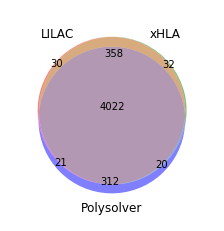

In [49]:
fig,ax = plt.subplots(figsize=(5,4))
venn3(subsets = l, set_labels = ('LILAC', 'xHLA', 'Polysolver'), alpha = 0.5, normalize_to=0.2,ax=ax)
plt.savefig(f'../results/figures/figure1/venn_hartwig_all.pdf', dpi=800,bbox_inches="tight")

In [50]:
l=[0,0,0,0,0,0,0]
for donor in d_data:
    # only one method
    lilac_only = len( set(d_data[donor]["LILAC"]["tumor"]) - set(d_data[donor]["polysolver"]["tumor"]) - set(d_data[donor]["xHLA"]["tumor"])) > 0
    poly_only = len(set(d_data[donor]["polysolver"]["tumor"]) - set(d_data[donor]["LILAC"]["tumor"]) - set(d_data[donor]["xHLA"]["tumor"])) > 0
    xhla_only = len(set(d_data[donor]["xHLA"]["tumor"]) - set(d_data[donor]["polysolver"]["tumor"]) - set(d_data[donor]["LILAC"]["tumor"])) > 0
    
    # two methods 
    lilac_polysolver=len(set(d_data[donor]["LILAC"]["tumor"]).intersection(set(d_data[donor]["polysolver"]["tumor"])) - set(d_data[donor]["xHLA"]["tumor"])) > 0
    lilac_xhla=len(set(d_data[donor]["LILAC"]["tumor"]).intersection(set(d_data[donor]["xHLA"]["tumor"])) - set(d_data[donor]["polysolver"]["tumor"])) > 0  
    polysolver_xhla=len(set(d_data[donor]["polysolver"]["tumor"]).intersection(set(d_data[donor]["xHLA"]["tumor"])) - set(d_data[donor]["LILAC"]["tumor"])) > 0
    
    # three methods
    
    three= len(set(d_data[donor]["LILAC"]["tumor"]).intersection(set(d_data[donor]["polysolver"]["tumor"])).intersection(set(d_data[donor]["xHLA"]["tumor"]))) == 6
    l=[l[0]+int(lilac_only),l[1]+int(xhla_only),l[2]+int(lilac_xhla),l[3]+int(poly_only),l[4]+int(lilac_polysolver),l[5]+int(polysolver_xhla),l[6]+int(three)]

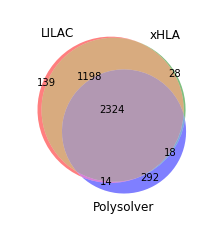

In [51]:
fig,ax = plt.subplots(figsize=(5,4))
venn3(subsets = l, set_labels = ('LILAC', 'xHLA', 'Polysolver'), alpha = 0.5, normalize_to=0.2,ax=ax)
plt.savefig(f'../results/figures/figure1/venn_hartwig_wt.pdf', dpi=800,bbox_inches="tight")

### Save table, HLA-I typing Hartwig

In [52]:
wt_samples = list(df[(df["loh_lilac"]==False)&(df["del_HLA-A"]==0)&(df["del_HLA-B"]==0)&(df["del_HLA-C"]==0)&(df["mut_hla_lilac"]==False)]["sample_id"].values)

In [53]:
l=[]
for donor in d_data:
    row,labels=[],[]
    for method in ["LILAC","xHLA","polysolver"]:
        for cat in ["normal","tumor"]:
            v=d_data[donor][method][cat]
            if len(v) < 6:
                print ("HE")
            row+=v
            for a in ["A","B","C"]:
                for i in range(1,3):
                    labels.append(method+"_"+cat[0]+"_"+f"{a}{i}")
   
    l.append([donor]+row)
df_sup = pd.DataFrame(l,columns=["sample_id"]+labels)
df_sup["is_mutated"]=df_sup.apply(lambda row: not(row["sample_id"] in wt_samples),axis=1)
df_sup=df_sup.merge(df_meta[["sample_id","sample_id_2"]].drop_duplicates())
df_sup.drop(["sample_id"],axis=1).rename(columns={"sample_id_2":"sampleId"}).to_csv("data/hla_typing_hartwig_full.tsv",sep="\t",index=False) # This will be part of Supp. Table 2 